In [1]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from astropy.time import Time
from astropy.coordinates import get_moon, GCRS
import astropy.units as u
import copy

#### This notebook is functional-ish, but doesn't interpolate to check colors post-peak yet (in the case where there isn't data for both filters in a given night
The purpose of this notebook is to search through the COSMOS field objects to identify candidates that are likely $\bf{Type\,Ia}$ supernovae. This is done by selecting every candidate that has at least 10 detections over at least 1 month, with a change of at least 1.4 mag, and that doesn't increase in brightness more than once (numbers adjustable in next cell)

##### This differs from the other SNsearch filter by requiring red colors post-peak

In [2]:
tspanr, tspang = 10, 10
numdetr, numdetg = 10, 10
minmagr, minmagg = 0.4, 0.4
errmult = 0.3
rmaxerr, gmaxerr = 0.2, 0.2

In [3]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect( f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'" )

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


The purpose of this notebook is to search through the COSMOS field objects to identify candidates that are likely supernovae. This is done by selecting every candidate that has at least 10 detections over at least 15 days, with a change of at least 1.4 mag, and that doesn't increase in brightness more than once (numbers adjustable in next cell)

In [4]:
query = ( 'SELECT o.candidate_id, o.id, e.mjd, o.mag, e.filter, o.magerr, o.ra, o.dec, e.filename FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'AND o.rb>0.5 '
         'ORDER BY o.candidate_id '
         'LIMIT 10000000')
cursor.execute( query )

SNquery = np.array(cursor.fetchall()).transpose()

#### Nonstandard exposure time filter

In [5]:
lutable = np.loadtxt("./archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

fnms = SNquery[8]
fnms = [fnms[i][:21] for i in range(len(fnms))] # truncate filenames to match lookup table format


In [6]:
exptime = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [7]:
# Eliminate objects from non-standard images
gmsk = np.where((SNquery[4]=="g") & (exptime>50))[0]
rmsk = np.where((SNquery[4]=="r") & (exptime>20))[0]
imsk = np.where((SNquery[4]=="i") & (exptime>20))[0]
grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)
len(grimsk)

133190

#### Red filter:

In [8]:
# Mask to make sure we stay in the r band detections
rmsk = np.where(SNquery[4] == "r")[0]
rmsk = [i for i in grimsk if i in rmsk]

In [9]:
### Everything in this section is the same as above besides some altered variable names
gmsk = np.where(SNquery[4] == "g")[0]
gmsk = [i for i in grimsk if i in gmsk]

In [10]:
# Separating out various query results and applying the r mask 
candsr, objs, magsr, magerrsr = SNquery[0][rmsk], SNquery[1].astype(float)[rmsk], SNquery[3][rmsk], SNquery[5][rmsk]
# Create an array of the dates rounded to the nearest MJD
odatesr = np.round(SNquery[2].astype(float))[rmsk]
# Create an array of unique candidates
ucandsr = np.unique(candsr)
# create an array of unique night (rounded to nearest MJD)
datesr = np.unique(odatesr)

In [11]:
candsg, objs, magsg, magerrsg = SNquery[0][gmsk], SNquery[1].astype(float)[gmsk], SNquery[3][gmsk], SNquery[5][gmsk]
odatesg = np.round(SNquery[2].astype(float))[gmsk]
ucandsg = np.unique(candsg)
datesg = np.unique(odatesg)

In [12]:
### The most computationally intensive cell in the notebook (along with its g band counterpart), should take less than 2 minutes
# Create for each unique candidate an array of the dates it was observed on and store those arrays in a larger array (ucanddatesr)
ucanddatesr = np.array([odatesr[np.where(candsr==i)[0]] for i in ucandsr])
# Create for each unique candidate an array of measured magnitudes and store those arrays in a larger array (ucandmagsr)
ucandmagsr = np.array([magsr[np.where(candsr==i)[0]] for i in ucandsr])
# Create for each unique candidate an array of measured magnitude error bars and store those arrays in a larger array (ucandmagerrsr)
ucandmagerrsr = np.array([magerrsr[np.where(candsr==i)[0]] for i in ucandsr])

In [13]:
%%time
ucanddatesg = np.array([odatesg[np.where(candsg==i)[0]] for i in ucandsg])
ucandmagsg = np.array([magsg[np.where(candsg==i)[0]] for i in ucandsg])
ucandmagerrsg = np.array([magerrsg[np.where(candsg==i)[0]] for i in ucandsg])

CPU times: user 1min 14s, sys: 38.9 s, total: 1min 53s
Wall time: 1min 54s


In [14]:
# Convert those arrays (previously strings to keep NumPy happy) to floats
ucandmagsr = np.array([i.astype(float) for i in ucandmagsr])
ucandmagerrsr = np.array([i.astype(float) for i in ucandmagerrsr])
ucanddatesr = np.array([i.astype(float) for i in ucanddatesr])

In [15]:
ucandmagsg = np.array([i.astype(float) for i in ucandmagsg])
ucandmagerrsg = np.array([i.astype(float) for i in ucandmagerrsg])
ucanddatesg = np.array([i.astype(float) for i in ucanddatesg])

In [16]:
ucandrangeg = np.array([np.max(i) - np.min(i) for i in ucanddatesg])
ucandnumg = np.array([len(i) for i in ucanddatesg])

In [17]:
# Calculate how many days passed between the first and last detection 
ucandranger = np.array([np.max(i) - np.min(i) for i in ucanddatesr])
# Calculate how many total times the candidates was detected
ucandnumr = np.array([len(i) for i in ucanddatesr])

In [18]:
# Make timespan and number of detection cuts
cut1r = np.where(ucandranger > tspanr)[0] # eliminate candidates whose detections dont span at least a month
cut2r = np.where(ucandnumr >= numdetr)[0] # eliminate candidates with fewer than 20 detections
cut3r = np.array([i for i in cut1r if i in cut2r]).astype(np.int64) # merge the masks

In [19]:
cut1g = np.where(ucandrangeg > tspang)[0] # eliminate candidates whose detections dont span at least a month
cut2g = np.where(ucandnumg > numdetg)[0] # eliminate candidates with fewer than 20 detections
cut3g = np.array([i for i in cut1g if i in cut2g]).astype(np.int64) # merge the masks

In [20]:
# Apply those cuts
cutcandsr = ucandsr[cut3r]
cutdatesr = ucanddatesr[cut3r]
cutmagsr = ucandmagsr[cut3r]
cutmagerrsr = ucandmagerrsr[cut3r]

# Create another cut for the minimum amplitude in mag
cutmagranger = np.array([np.max(i) - np.min(i) for i in cutmagsr])
cut6r = np.where(cutmagranger > minmagr)[0]

# Create another cut for where the magerror is too high
cutmagerrranger = np.array([np.mean(i) for i in cutmagerrsr])
cut5r = np.where(cutmagerrranger < rmaxerr)[0]

cut4r = np.array([i for i in cut5r if i in cut6r]).astype(np.int64)

# And apply that cut as well
cutcandsr = ucandsr[cut3r][cut4r]
cutdatesr = ucanddatesr[cut3r][cut4r]
cutmagsr = ucandmagsr[cut3r][cut4r]
cutmagerrsr = ucandmagerrsr[cut3r][cut4r]

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [21]:
cutcandsg = ucandsg[cut3g]
cutdatesg = ucanddatesg[cut3g]
cutmagsg = ucandmagsg[cut3g]
cutmagerrsg = ucandmagerrsg[cut3g]

cutmagrangeg = np.array([np.max(i) - np.min(i) for i in cutmagsg])
cut6g = np.where(cutmagrangeg > minmagg)[0]
# Create another cut for where the magerror is too high
cutmagerrrangeg = np.array([np.mean(i) for i in cutmagerrsg])
cut5g = np.where(cutmagerrrangeg < gmaxerr)[0]

cut4g = np.array([i for i in cut5g if i in cut6g])


cutcandsg = ucandsg[cut3g][cut4g]
cutdatesg = ucanddatesg[cut3g][cut4g]
cutmagsg = ucandmagsg[cut3g][cut4g]
cutmagerrsg = ucandmagerrsg[cut3g][cut4g]

In [22]:
# Create new arrays with the same dimensions as the cutdatesr, cutmagsr, and cutmagerrs arrays (those share dimensions)
cutdatesr2 = copy.deepcopy(cutdatesr)
nightr = copy.deepcopy(cutdatesr)
nightrmag = copy.deepcopy(cutdatesr)
nightrmagerr = copy.deepcopy(cutdatesr)

for i in range(len(cutdatesr2)):
    # make an array of every night the candidate in question (candidate "i") was detected
    unightr = np.unique(cutdatesr2[i])
    for j in range(len(unightr)):
        # For each of those nights, make a mask that selects every observation that night
        msk = np.where(cutdatesr2[i] == unightr[j])[0]
        # Populate the arrays we created earlier in the cell with appropriate values for the night of the observation,
        # the average magnitude measured that night, and the error (propogated from individual errors) in that average measurement
        # NOTE: there will be meaningless numbers at the end of each (nightr/nightrmag/nightrmagerr)[i] array, left over from
        # when we created them by copying another array. It isn't elegant but it is accounted for
        nightr[i][j] = unightr[j]
        nightrmag[i][j] = np.mean(cutmagsr[i][msk])
        nightrmagerr[i][j] = np.sqrt(np.sum(cutmagerrsr[i][msk]**2))

In [23]:
cutdatesg2 = copy.deepcopy(cutdatesg)
nightg = copy.deepcopy(cutdatesg)
nightgmag = copy.deepcopy(cutdatesg)
nightgmagerr = copy.deepcopy(cutdatesg)

for i in range(len(cutdatesg2)):
    unightg = np.unique(cutdatesg2[i])
    for j in range(len(unightg)):
        msk = np.where(cutdatesg2[i] == unightg[j])[0]
        nightg[i][j] = unightg[j]
        nightgmag[i][j] = np.mean(cutmagsg[i][msk])
        nightgmagerr[i][j] = np.sqrt(np.sum(cutmagerrsg[i][msk]**2))

In [24]:
# Create an array of dataframes. Each dataframe represents one candidate, and each contains "Night", "Mag", and "Magerr" columns, 
# with each row representing one night
dfr = [pd.DataFrame(np.array(
    [nightr[i][:len(np.unique(nightr[i]))], 
     nightrmag[i][:len(np.unique(nightr[i]))], 
     nightrmagerr[i][:len(np.unique(nightr[i]))]]).transpose(),
    columns=["Night",
            "Mag",
            "Magerr"])
 for i in range(len(cutcandsr))]

In [25]:
dfg = [pd.DataFrame(np.array(
    [nightg[i][:len(np.unique(nightg[i]))], 
     nightgmag[i][:len(np.unique(nightg[i]))], 
     nightgmagerr[i][:len(np.unique(nightg[i]))]]).transpose(),
    columns=["Night",
            "Mag",
            "Magerr"])
 for i in range(len(cutcandsg))]

In [26]:
# This cell creates a mask to eliminate variable stars from the search:
varstarmskr = np.ones(len(dfr), dtype=bool)
peakdates = np.zeros(len(dfr), dtype=float)
for i in range(len(dfr)):
# for i in [614]:
    num = 0
    h=0
    # First, make sure that the dataframes in the dfr array are each in chronological order
    dfr[i] = dfr[i].sort_values(by="Night")
    dfg[i] = dfg[i].sort_values(by="Night")
    k = np.where(cutcandsg==cutcandsr[i])[0]
    for j in range(len(dfr[i]["Mag"]) - 1):
        h +=1
        if (num >= 0) & (num < 1):
            # On the rise, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfr[i]["Mag"][j]+errmult*dfr[i]["Magerr"][j] > dfr[i]["Mag"][j+1]-errmult*dfr[i]["Magerr"][j+1]:
                pass
            else:
                # Once that condition isn't met, 'num' changes, sending us to the descending loop
                num+=1
                peakdates[i] = dfr[i]["Night"][j]
        if (num >= 1) & (num < 2):
            # After peak in r filter, requires that the source be brighter in r than in g
#             print(k)
            if len(k) != 0:
                gmag = dfg[k[0]]["Mag"][np.where(dfg[k[0]]["Night"] == dfr[i]["Night"][j])[0]]
#                 print(gmag)
                if len(gmag) == 0:
                    pass
#                     nightdiff = np.array(dfg[k[0]]["Night"]) - dfr[i]["Night"][j]
#                     if nightdiff.any > 0:
#                         nextdt = np.min(np.where(nightdiff>0))
#                         gmag = np.interp(dfr[i]["Night"][j],[dfg[k[0]]["Night"][np.max([0,nextdt-1])],dfg[k[0]]["Night"][nextdt]], [dfg[k[0]]["Mag"][np.max([0,nextdt-1])],dfg[k[0]]["Mag"][nextdt]] )
#                         if gmag < dfr[i]["Mag"][j]:
#                             num +=1
                elif np.array(gmag)[0] < dfr[i]["Mag"][j]:
                    num += 1
            # On the decline, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfr[i]["Mag"][j]-errmult*dfr[i]["Magerr"][j] < dfr[i]["Mag"][j+1]+errmult*dfr[i]["Magerr"][j+1]:
                pass
            else:
                # If this fails, it means that we went up, down, and up again--not a SN, so
                num+=1
        if num == 2:# and h<10:
            # We make a note of that in the 'varstarmskr' mask
            varstarmskr[i] = False

In [27]:
varstarmskg = np.ones(len(dfg), dtype=bool)

for i in range(len(dfg)):
    num = 0
    h = 0
    dfg[i] = dfg[i].sort_values(by="Night")
    for j in range(len(dfg[i]["Mag"]) - 1):
        h+=1
        if (num >= 0) & (num < 1):
            if dfg[i]["Mag"][j]+errmult*dfg[i]["Magerr"][j] > dfg[i]["Mag"][j+1]-errmult*dfg[i]["Magerr"][j+1]:
                pass
            else:
                num+=1
                
        if (num >= 1) & (num < 2):
#             k = np.where(cutcandsr==cutcandsg[i])[0]
#             if len(k) != 0:
#                 rmag = dfr[k[0]]["Mag"][np.where(dfr[k[0]]["Night"] == dfg[i]["Night"][j])[0]]
#                 if len(rmag) != 0:
#                     if np.array(rmag > dfg[i]["Mag"][j])[0]:
#                         num += 1
            
            if dfg[i]["Mag"][j]-errmult*dfg[i]["Magerr"][j] < dfg[i]["Mag"][j+1]+errmult*dfg[i]["Magerr"][j+1]:
                pass
            else:
                num+=1
        
        if num == 2:# and h<10:
            varstarmskg[i] = False

In [28]:
# Create lists of the candidates that passed each test
SNr = np.array([[cutcandsr[f], peakdates[f]] for f in np.array(range(len(cutdatesr)))[varstarmskr]])
SNg = np.array([cutcandsg[f] for f in np.array(range(len(cutdatesg)))[varstarmskg]])

# Select the ones they share
SNrg = np.array([i for i in SNr if i[0] in SNg])

In [29]:
len(SNrg)

15

59313.0


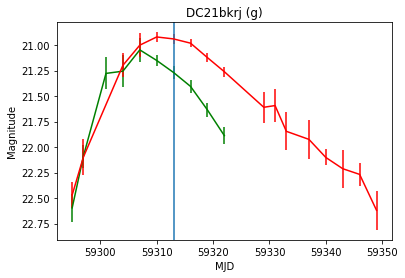

59361.0


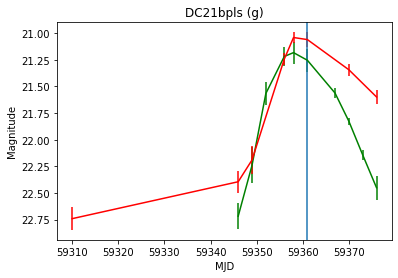

59319.0


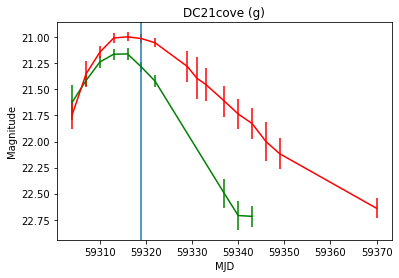

59310.0


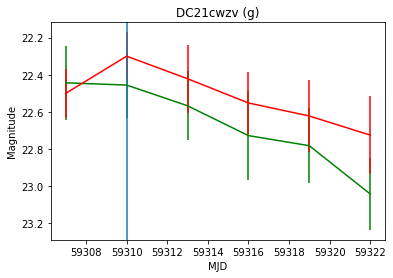

59333.0


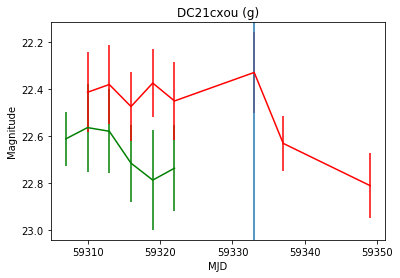

59333.0


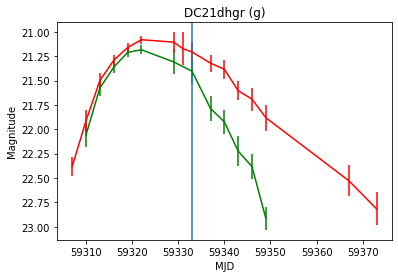

59322.0


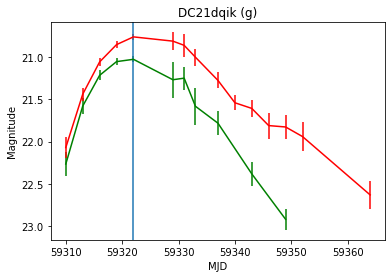

59331.0


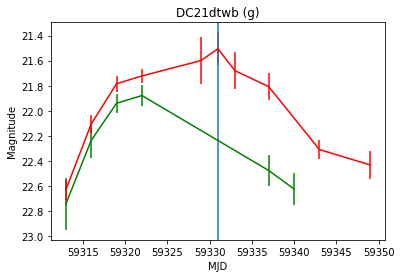

59331.0


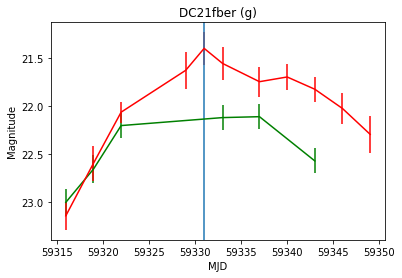

59356.0


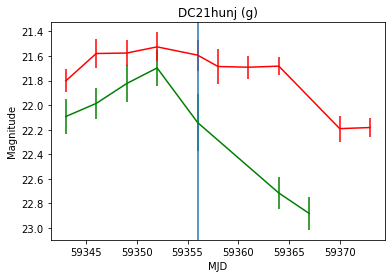

59370.0


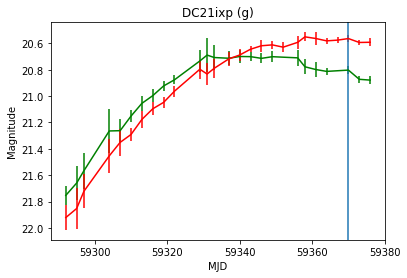

59304.0


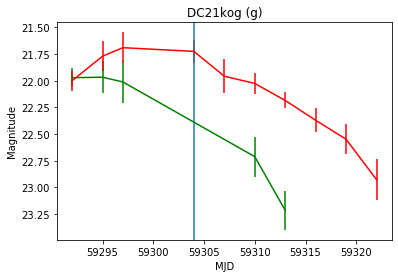

59295.0


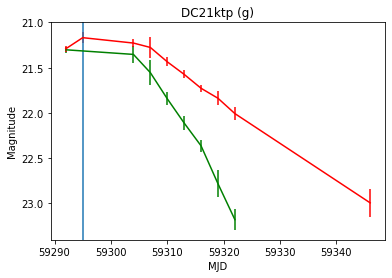

59304.0


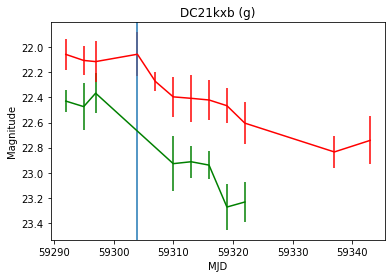

59313.0


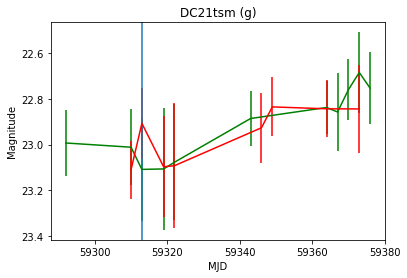

In [30]:
names = SNrg.transpose()[0]
pkdts = SNrg.transpose()[1].astype(float)
for i in range(len(names)):
    for f in np.array(range(len(cutcandsg))):
        if cutcandsg[f] == names[i]:
            g = len(np.unique(cutdatesg[f]))
            plt.errorbar(nightg[f][:g],nightgmag[f][:g], yerr=nightgmagerr[f][:g], color='g')
            plt.title(cutcandsg[f]+" (g)")
            plt.ylabel("Magnitude")
            plt.xlabel("MJD")
            plt.gca().invert_yaxis()
    
    for f in np.array(range(len(cutcandsr))):
        if cutcandsr[f] == names[i]:
            g = len(np.unique(cutdatesr[f]))
            plt.errorbar(nightr[f][:g],nightrmag[f][:g], yerr=nightrmagerr[f][:g], color='r')
            print(pkdts[i])
            if pkdts[i] != 0.0:
                plt.axvline(pkdts[i])
    plt.show()

#### A closer look at these SN

In [31]:
# Taking a look at their coordinates:
for i in SNrg.transpose()[0]:
    query = ('SELECT c.id, c.ra, c.dec FROM candidates c '
            'WHERE c.id=%s ')
    cursor.execute( query, (i, ) )
    print(cursor.fetchall())

[['DC21bkrj', 150.043978544436, 3.47660190275974]]
[['DC21bpls', 149.300808259448, 2.094409454409]]
[['DC21cove', 150.205260592532, 3.74323011868333]]
[['DC21cwzv', 150.677477620279, 2.43312798605649]]
[['DC21cxou', 150.17665779001, 4.05871167020173]]
[['DC21dhgr', 148.96669780135, 1.65455109542668]]
[['DC21dqik', 151.689426712647, 2.00556682067166]]
[['DC21dtwb', 149.302770735739, 1.77949389263242]]
[['DC21fber', 149.045078531139, 3.17994689983373]]
[['DC21hunj', 150.372933776757, 2.44328182430186]]
[['DC21ixp', 150.726849638736, 2.60341491739695]]
[['DC21kog', 151.123031420262, 1.10577376817372]]
[['DC21ktp', 149.385740426683, 2.8139035077278]]
[['DC21kxb', 150.732358932859, 2.95252258401769]]
[['DC21tsm', 150.186670367025, 1.69722870503495]]


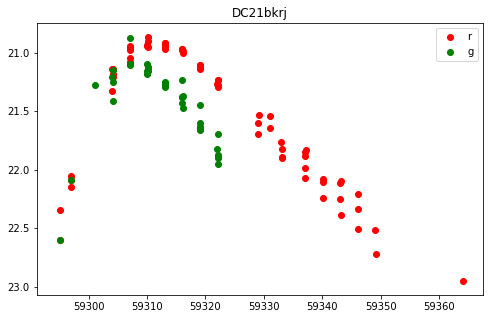

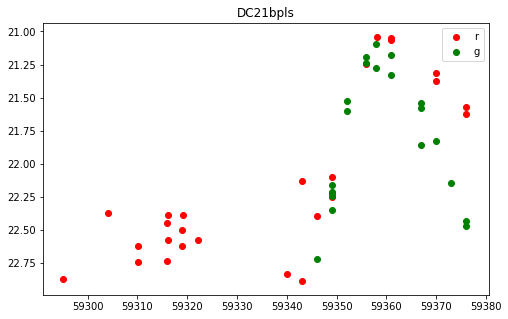

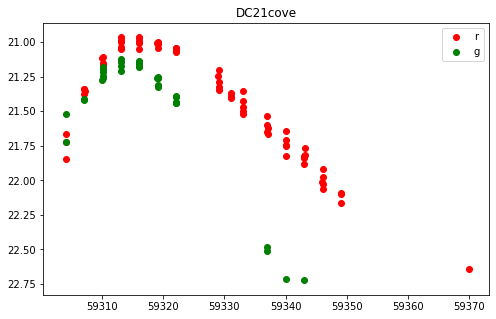

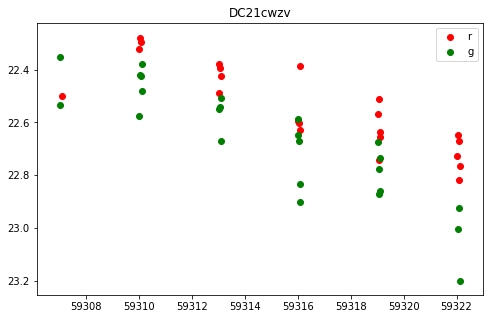

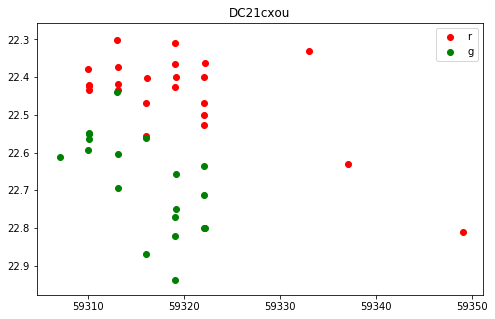

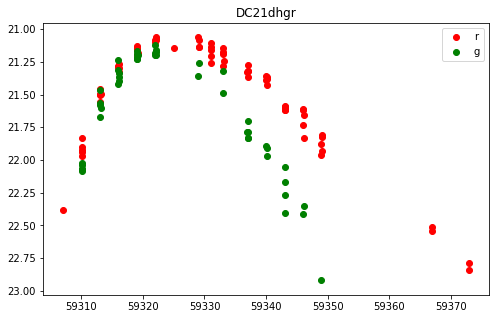

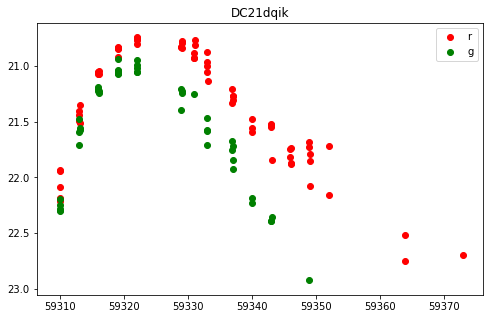

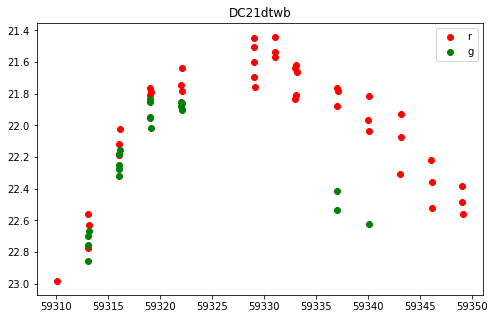

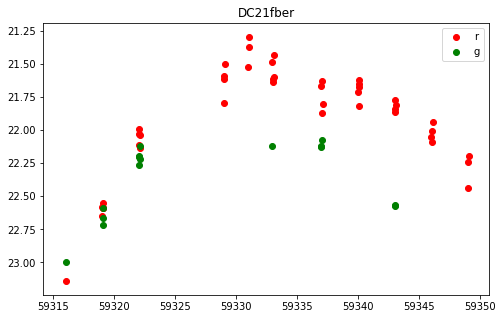

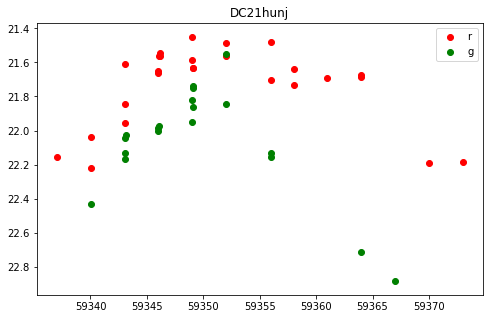

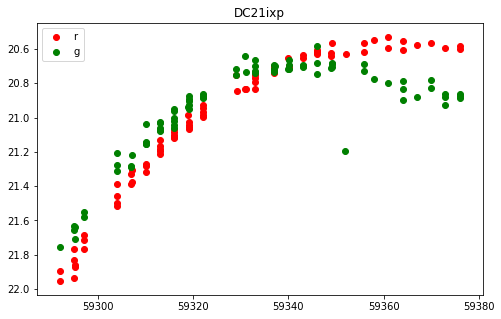

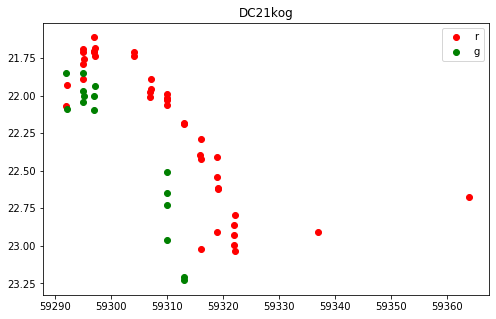

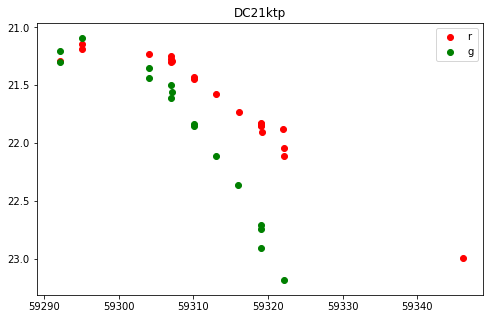

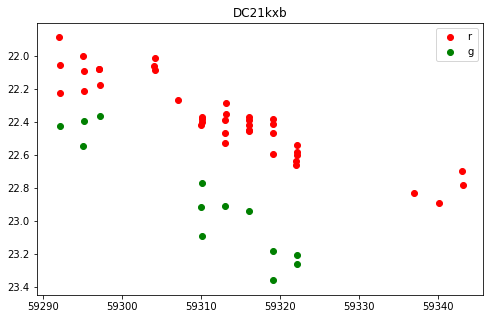

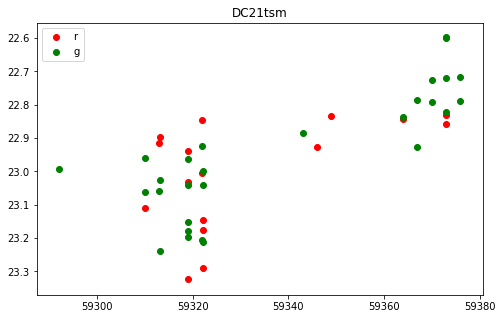

In [32]:
# Plotting lightcurves for each potential SN
for i in SNrg.transpose()[0]:
    query = ('SELECT c.id, e.mjd, o.mag, e.filter FROM objects o '
             'JOIN candidates c ON c.id=o.candidate_id '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN exposures e ON e.id=s.exposure_id '
            'WHERE c.id=%s ')
    cursor.execute( query, (i, ) )
    array = np.array(cursor.fetchall()).transpose()
    rmsk = np.where(array[3]=='r')[0]
    gmsk = np.where(array[3]=='g')[0]
    plt.figure(figsize=(8,5))
    plt.scatter((array[1][rmsk]).astype(float), (array[2][rmsk]).astype(float), color='r', label='r')
    plt.scatter((array[1][gmsk]).astype(float), (array[2][gmsk]).astype(float), color='g', label='g')
    plt.title(array[0][0])
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

In [34]:
### This cell pulls out the reference, science, and subtraction images for eack of the SNe the filter detected, for every good detection

for i in SNrg.transpose()[0]:
    query = ( 'SELECT cand.id, e.mjd,e.filename,e.filter,c.sci_jpeg,c.ref_jpeg,c.diff_jpeg FROM cutouts c '
              'INNER JOIN objects o ON c.object_id=o.id '
              'INNER JOIN candidates cand ON o.candidate_id=cand.id '
              'INNER JOIN subtractions s ON o.subtraction_id=s.id '
              'INNER JOIN exposures e ON s.exposure_id=e.id '
              'WHERE cand.id=%s '
              'AND o.rb>0.6'
              'ORDER BY e.mjd '
              'LIMIT 3')
    cursor.execute( query, ( i, ) )
    for row in cursor:
        label = ipywidgets.HTML( f'<b>Candidate</b>{row["id"]}<br><b>{row["filename"]}</b><br><b>Filter:</b> {row["filter"]}' )
        newimg = ipywidgets.Image( value=bytes(row["sci_jpeg"]), width=102, height=102, format='jpeg' )
        refimg = ipywidgets.Image( value=bytes(row["ref_jpeg"]), width=102, height=102, format='jpeg' )
        subimg = ipywidgets.Image( value=bytes(row["diff_jpeg"]), width=102, height=102, format='jpeg' )
        box = ipywidgets.HBox( [ newimg, refimg, subimg, label ] )
        display( box )
    print("")
    print("")    
    print("")    
    print("")    

#### I filter (for the future)

In [ ]:
# # Mask to make sure we stay in the r band detections
# imsk = np.where(SNquery[4] == "r")[0]

In [ ]:
# # Separating out various query results and applying the r mask 
# candsi, objs, magsi, magerrsi = SNquery[0][imsk], SNquery[1].astype(float)[imsk], SNquery[3][imsk], SNquery[5][imsk]
# # Create an array of the dates rounded to the nearest MJD
# odatesi = np.round(SNquery[2].astype(float))[imsk]
# # Create an array of unique candidates
# ucandsi = np.unique(candsi)
# # create an array of unique night (rounded to nearest MJD)
# datesi = np.unique(odatesi)

In [ ]:
# # The most computationally intensive cell in the notebook (along with its g band counterpart), should take less than 2 minutes

# # Create for each unique candidate an array of the dates it was observed on and store those arrays in a larger array (ucanddatesr)
# ucanddatesi = np.array([odatesi[np.where(candsi==i)[0]] for i in ucandsi])
# # Create for each unique candidate an array of measured magnitudes and store those arrays in a larger array (ucandmagsr)
# ucandmagsi = np.array([magsi[np.where(candsi==i)[0]] for i in ucandsi])
# # Create for each unique candidate an array of measured magnitude error bars and store those arrays in a larger array (ucandmagerrsr)
# ucandmagerrsi = np.array([magerrsi[np.where(candsi==i)[0]] for i in ucandsi])

In [ ]:
# # Convert those arrays (previously strings) to floats
# ucandmagsi = np.array([i.astype(float) for i in ucandmagsi])
# ucandmagerrsi = np.array([i.astype(float) for i in ucandmagerrsi])
# ucanddatesi = np.array([i.astype(float) for i in ucanddatesi])

In [ ]:
# # Calculate how many days passed between the first and last detection 
# ucandrangei = np.array([np.max(i) - np.min(i) for i in ucanddatesi])
# # Calculate how many total times the candidates was detected
# ucandnumi = np.array([len(i) for i in ucanddatesi])

In [ ]:
# # Make timespan and number of detection cuts
# cut1i = np.where(ucandrangei > tspani)[0] # eliminate candidates whose detections dont span at least a month
# cut2i = np.where(ucandnumi >= numdeti)[0] # eliminate candidates with fewer than 20 detections
# cut3i = np.array([i for i in cut1i if i in cut2i]).astype(np.int64) # merge the masks

In [ ]:
# # Apply those cuts
# cutcandsi = ucandsi[cut3i]
# cutdatesi = ucanddatesi[cut3i]
# cutmagsi = ucandmagsi[cut3i]
# cutmagerrsi = ucandmagerrsi[cut3i]

# # Create another cut for the minimum amplitude in mag
# cutmagrangei = np.array([np.max(i) - np.min(i) for i in cutmagsi])
# cut6i = np.where(cutmagrangei > minmagi)[0]

# # Create another cut for where the magerror is too high
# cutmagerrrangei = np.array([np.mean(i) for i in cutmagerrsi])
# cut5i = np.where(cutmagerrrangei > maxerr)

# cut4i = np.array([i for i in cut5i if i in cut6i]).astype(np.int64)

# # And apply that cut as well
# cutcandsi = ucandsi[cut3i][cut4i]
# cutdatesi = ucanddatesr[cut3i][cut4i]
# cutmagsi = ucandmagsr[cut3i][cut4i]
# cutmagerrsi = ucandmagerrsi[cut3i][cut4i]



In [ ]:
# # Create new arrays with the same dimensions as the cutdatesr, cutmagsr, and cutmagerrs arrays (those share dimensions)
# import copy
# cutdatesi2 = copy.deepcopy(cutdatesi)
# nighti = copy.deepcopy(cutdatesi)
# nightimag = copy.deepcopy(cutdatesi)
# nightimagerr = copy.deepcopy(cutdatesi)

# for i in range(len(cutdatesi2)):
#     # make an array of every night the candidate in question (candidate "i") was detected
#     unighti = np.unique(cutdatesi2[i])
#     for j in range(len(unighti)):
#         # For each of those nights, make a mask that selects every observation that night
#         msk = np.where(cutdatesi2[i] == unighti[j])[0]
#         # Populate the arrays we created earlier in the cell with appropriate values for the night of the observation,
#         # the average magnitude measured that night, and the error (propogated from individual errors) in that average measurement
#         # NOTE: there will be meaningless numbers at the end of each (nightr/nightrmag/nightrmagerr)[i] array, left over from
#         # when we created them by copying another array. It isn't elegant but it is accounted for
#         nighti[i][j] = unighti[j]
#         nightimag[i][j] = np.mean(cutmagsi[i][msk])
#         nightimagerr[i][j] = np.sqrt(np.sum(cutmagerrsi[i][msk]**2))

In [ ]:
# # Create an array of dataframes. Each dataframe represents one candidate, and each contains "Night", "Mag", and "Magerr" columns, 
# # with each row representing one night
# dfi = [pd.DataFrame(np.array(
#     [nighti[i][:len(np.uniquei(nighti[i]))], 
#      nightimag[i][:len(np.unique(nighti[i]))], 
#      nightimagerr[i][:len(np.unique(nighti[i]))]]).transpose(),
#     columns=["Night",
#             "Mag",
#             "Magerr"])
#  for i in range(len(cutcandsi))]

In [ ]:
# # This cell creates a mask to eliminate variable stars from the search:
# varstarmski = np.ones(len(dfi), dtype=bool)
# for i in range(len(dfi)):
#     num = 0
#     h=0
#     # First, make sure that the dataframes in the dfr array are each in chronological order
#     dfi[i] = dfi[i].sort_values(by="Night")
#     for j in range(len(dfi[i]["Mag"]) - 1):
#         h +=1
#         if (num >= 0) & (num < 1):
#             # On the rise, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
#             if dfi[i]["Mag"][j]+dfi[i]["Magerr"][j] > dfi[i]["Mag"][j+1]-errmult*dfi[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 # Once that condition isn't met, 'num' changes, sending us to the descending loop
#                 num+=1
#         if (num >= 1) & (num < 2):
#             # On the decline, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
#             if dfi[i]["Mag"][j]-dfi[i]["Magerr"][j] < dfi[i]["Mag"][j+1]+errmult*dfi[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 # If this fails, it means that we went up, down, and up again--not a SN, so
#                 num+=1
# #         if num == 2:
# #             if dfi[i]["Mag"][j]+dfi[i]["Magerr"][j] > dfi[i]["Mag"][j+1]-errmult*dfi[i]["Magerr"][j+1]:
# #                 pass
# #             else:
# #                 num+=1
# #         if num == 3:
# #             if dfi[i]["Mag"][j]-dfi[i]["Magerr"][j] < dfi[i]["Mag"][j+1]+errmult*dfi[i]["Magerr"][j+1]:
# #                 pass
# #             else:
# #                 num+=1
#         if num == 2:# and h<10:
#             # We make a note of that in the 'varstarmskr' mask
#             varstarmski[i] = False

In [ ]:
# # Plotting only those that passed through the i-band filter
# for f in np.array(range(len(cutdatesi)))[varstarmski]:
#     g = len(np.unique(cutdatesi[f]))
# #     plt.errorbar(nighti[f][:g],nightimag[f][:g], yerr=nightimagerr[f][:g])
# #     plt.title(cutcandsi[f] + " (i)")
# #     plt.ylabel("Magnitude")
# #     plt.xlabel("MJD")
# #     plt.gca().invert_yaxis()
# #     plt.show()